# A simple, yet complete, tutorial on how use the CCS_fit module to fit two-body interactions

In [1]:
#REMOVE SOME HARD CODING. FOR EXAMPLE: "Ne-Ne" and "Ne" which is used further down.


import numpy as np
from ase.io import read,write
from ase.build import bulk
import ase.db as db
from ase.visualize import view
from ase.calculators.lj import LennardJones

atom = 'Fe'


LJ=bulk(atom,'fcc', a=1.55)
LJ=LJ*[2, 2, 2]
calc = LennardJones()
LJ.calc = calc 

Fit_on_forces=True  #Enable/disable option for fitting CCS potential to atomic forces. 



### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


In [2]:
# CHECK THE RATTLE FUNCTION TO MAKE SURE THAT WE DO NOT GET THE SAME RATTLES EVERY TIME

orig_cell = LJ.get_cell()
orig_struc = LJ.copy()

displacement_magnitude=0.02  # 0.02 and disp_steps 5 leads to decieving results!
disp_steps=5
rounds=2 # Decreased the rounds by a factor of 10 to increase the speed during testing phase.

trainset_list="file_list" # List of strucutres to include in the data-base (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(0.96, 1.04, 9):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.set_cell(new_cell)
        new_struc.calc = calc
        nrg = new_struc.get_potential_energy()
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.rattle(displacement_magnitude*i)
            rattle_struc.calc = calc
            nrg = rattle_struc.get_potential_energy()
            if nrg < -40:
                xyz_file=f"CALCULATED_DATA/S{counter}.xyz"
                write(xyz_file, rattle_struc)
                print(xyz_file, file=f)
                counter += 1

f.close()
       

### BUILD REFERENCE DATA-BASE

After generating the data, we collect it in an ASE database file. The ``file_list`` is a file containing a list of files to be collected into the data base.

Example of a ``file_list`` file:

    CALCULATED_DATA/S2.xyz
    CALCULATED_DATA/S3.xyz
    CALCULATED_DATA/S4.xyz
    CALCULATED_DATA/S5.xyz
    CALCULATED_DATA/S6.xyz
    CALCULATED_DATA/S7.xyz
    CALCULATED_DATA/S8.xyz
    CALCULATED_DATA/S9.xyz



In [3]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode='CSS', DFT_DB='LJ.db', file_list='file_list', overwrite=True)

    Building data-bases: 100%|██████████| 68/68 [00:22<00:00,  3.01it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [4]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="LJ.db",include_forces=Fit_on_forces)

    Fetching data: 100%|██████████| 68/68 [00:02<00:00, 22.95it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [5]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                f'{atom}-{atom}': {
                        "Rcut": 5.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono"

                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [6]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Fe']
    Applying monotonous constraints for pair:  Fe-Fe
    Merging intervall for pair Fe-Fe. Number of knots reduced from 411 to 405. 
    Condition number is: 191438148716797.5 ( 405 2949937.5649102023 1.540975447816699e-08)


    Finding optimum switch: 100%|██████████| 405/405 [00:28<00:00, 14.40it/s]


    The best switch is (40,) with mse: 0.003137 
    Final root mean square error in fit:  0.0006270517615822516  (eV/atoms) [NOTE: Only elements specified in Onebody are considered!]


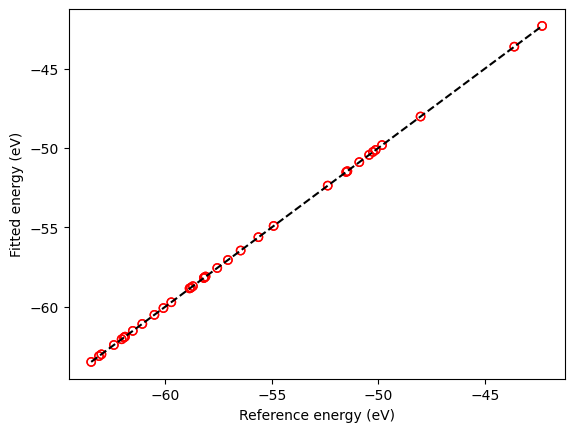

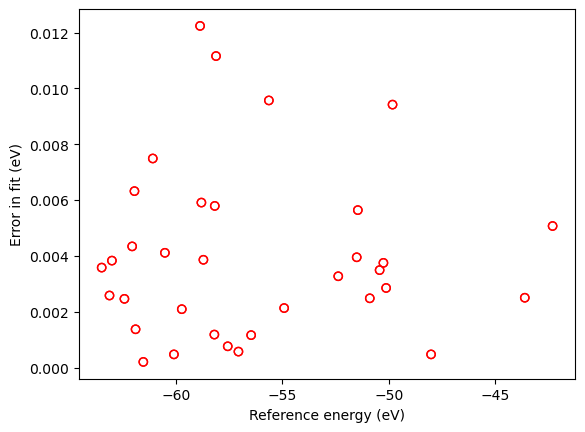

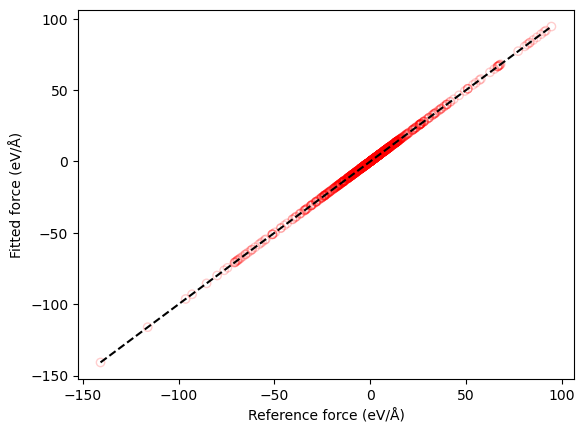

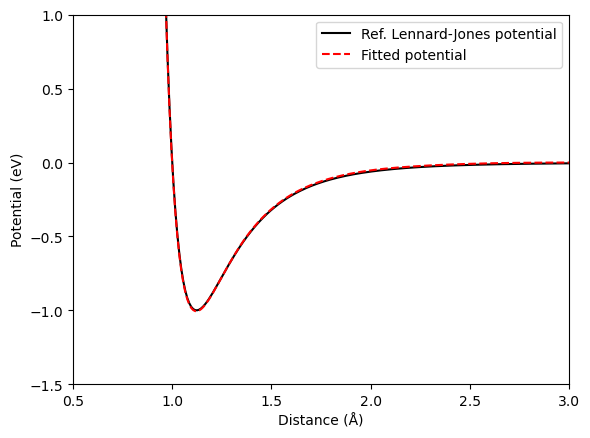

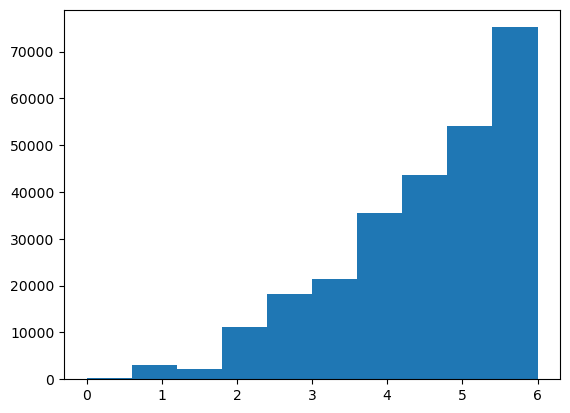

In [7]:
import matplotlib.pyplot as plt

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)

r=np.array(CCS_params["Two_body"][f'{atom}-{atom}']["r"])
e=CCS_params["Two_body"][f'{atom}-{atom}']["spl_a"]

try:
    err=np.loadtxt("CCS_error.out")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Fitted energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

try:
    err_F=np.loadtxt("CCS_error_forces.out")
    plt.xlabel('Reference force (eV/Å)')
    plt.ylabel('Fitted force (eV/Å)')
    plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
    plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
    plt.show()
except:
    pass

e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)
plt.xlim(0.5,3)
plt.ylim(-1.5,1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()

d=[]
for t in training_set["energies"]:
    d.extend(training_set["energies"][t][f'{atom}-{atom}'])

plt.hist(d)
plt.show()


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [9]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="LJ.db")

100%|██████████| 68/68 [00:23<00:00,  2.95it/s]


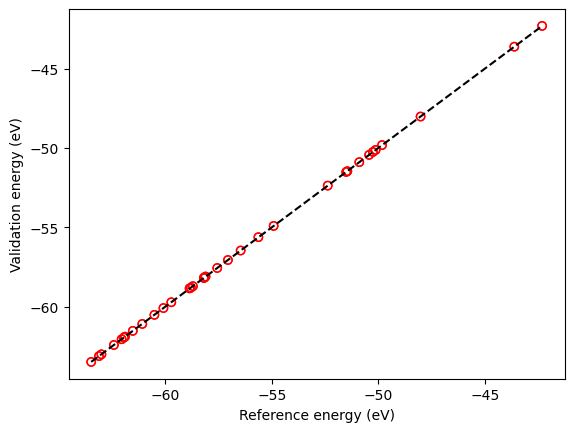

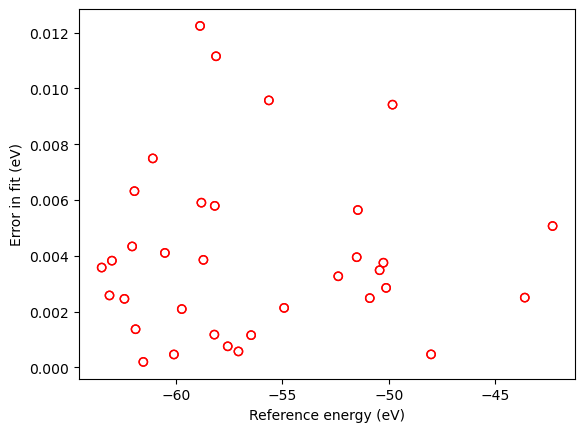

In [10]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

### Geometry optimization

In [11]:
"""Should be able to do solely with ASE
Ask Thijs how to use calculator."""
from ase.optimize import BFGS 
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from tqdm import tqdm
from ase import io

struct = db.connect('LJ.db')
calc = CCS(CCS_params=CCS_params)

for row in tqdm(struct.select(), total=len(struct)):
    structure = row.toatoms()
    structure.calc = calc
    structure.get_forces()
    struct.write(structure, CCS=True)

opt = BFGS(structure, trajectory='opt.traj')
opt.run(fmax=0.05)

  0%|          | 0/68 [00:00<?, ?it/s]/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/ase/db/core.py:105: UserWarning: It is best not to use keys (CCS) that are also a chemical formula.  If you do a "db.select('CCS')",you will not find rows with your key.  Instead, you wil get rows containing the atoms in the formula!
  warnings.warn(
100%|██████████| 68/68 [00:27<00:00,  2.48it/s]

      Step     Time          Energy         fmax
BFGS:    0 13:02:12      -49.817908      105.8860
BFGS:    1 13:02:12      -53.675703       63.1129


BFGS:    2 13:02:12      -51.531401       57.7915
BFGS:    3 13:02:12      -44.590903      109.2743
BFGS:    4 13:02:12      -38.597750      131.1631
BFGS:    5 13:02:13      -39.553555      116.5946
BFGS:    6 13:02:13      -42.795362      106.8526
BFGS:    7 13:02:13      -46.853034      116.8188
BFGS:    8 13:02:13      -53.889876       42.6043
BFGS:    9 13:02:13      -50.601565       86.8219
BFGS:   10 13:02:13      -56.501584       27.5763
BFGS:   11 13:02:13      -55.057277       39.6690
BFGS:   12 13:02:13      -53.583033       51.9741
BFGS:   13 13:02:14      -54.725863       48.0461
BFGS:   14 13:02:14      -57.533746       24.9048
BFGS:   15 13:02:14      -46.609546       90.4710
BFGS:   16 13:02:14      -57.775383       26.1961
BFGS:   17 13:02:14      -45.410867      134.6292
BFGS:   18 13:02:14      -58.677451       15.8997
BFGS:   19 13:02:14      -53.560194       59.2434
BFGS:   20 13:02:14      -59.907380        7.2135
BFGS:   21 13:02:15      -60.104739        4.4107


True

### Equation of state

In [11]:
from ase import Atoms
from ase.io.trajectory import Trajectory
from ase.calculators.emt import EMT
from ase.units import kJ
from ase.eos import EquationOfState

a = 2.866 # Lattice constant for BCC Fe
b = a / 2
Fe = Atoms('Fe', 
cell=[(-b, b, b), (b, -b, b), (b, b, -b)], 
pbc=1,
calculator=LennardJones())
cell = Fe.get_cell()
traj = Trajectory('Fe.traj', 'w')
for x in np.linspace(0.95, 1.05, 5):
    Fe.set_cell(cell * x, scale_atoms=True)
    Fe.get_potential_energy()
    traj.write(Fe)



NotImplementedError: No EMT-potential for Fe

### Phonon spectra

In [ ]:
### Do solely with phonopy even though some parts may be done with ASE

### Cleaning up

In [43]:
import glob
import os

def rm(file):
    try:
        os.remove(file)
    except OSError:
        pass


list=glob.glob("CALCULATED_DATA/*")
for file in list:
    rm(file)
list=glob.glob("CCS_*")
for file in list:
    rm(file)
rm("structures.json")
rm("file_list")
rm("LJ.db")
